# News Popularity Prediction - Starter Notebook

## 0. Problem statement

In this competition, you will build Regression models which accurately predict the popularity of new articles (the number of times it w will be shared online) based on ~60 features provided to you.

**Importance of online news**

The consumption of online news is expediting day by day due to the extensive adoption of smartphones and the rise of social networks. Note that online news content comprises various key properties. For example, it is easily produced and small in size; its lifespan is short and the cost is low. Such Qualities make news content more effective to be consumed on social sharing platforms. More interestingly, this sort of content can capture the eye of a signiﬁcant amount of Internet users within a brief period of your time. As a result, the main target on the analysis of online news content like predicting the recognition of stories articles, demonstrating the decay of interest over time to know the world of online news has greatly increased since it has so many practical meanings.

**Why news popularity prediction?**

There are multiple areas of applications for online news popularity prediction. Some of these benefits include gaining better insights into the audience consuming online news content. Consequently, it increases the ability of news organizations to deliver more relevant and appealing content in a proactive manner as well as the company can allocate resources more wisely to prepare stories over their life cycle. Moreover, prediction of news content is also beneﬁcial for trend forecasting, understanding the collective human behavior, advertisers to propose more proﬁtable monetization techniques, and readers to ﬁlter the huge amount of information quickly and efﬁciently.

## Loading data: Libraries and necessary files

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [104]:
import pandas as pd
import numpy as np
import os

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_val_score


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [105]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [106]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(29733, 61)
(9911, 60)
(9911, 2)
(61, 3)


Lets analyse the features that are given to us. As detailed in the Data section of the competition page, the features provided come from different sources and have been categorized into various types. Some of these are coming directly from other NLP (Natural language processing) models. Let's print and try to categorize the variable names for better analysis.

In [107]:
# Lets print the feature name with descriptions
for i in data_dict.iterrows():
    print(i[1]['column'],':',i[1]['description'])

url : URL of the article (non-predictive)
timedelta : Days between the article publication and the dataset acquisition (non-predictive)
ntokenstitle : Number of words in the title
ntokenscontent : Number of words in the content
nuniquetokens : Rate of unique words in the content
nnonstop_words : Rate of non-stop words in the content
nnonstopuniquetokens : Rate of unique non-stop words in the content
num_hrefs : Number of links
numselfhrefs : Number of links to other articles published by Mashable
num_imgs : Number of images
num_videos : Number of videos
averagetokenlength : Average length of the words in the content
numkeywords : Number of keywords in the metadata
datachannelislifestyle : Is data channel 'Lifestyle'?
datachannelis_entertainment : Is data channel 'Entertainment'?
datachannelis_bus : Is data channel 'Business'?
datachannelis_socmed : Is data channel 'Social Media'?
datachannelis_tech : Is data channel 'Tech'?
datachannelis_world : Is data channel 'World'?
kwminmin : Wors

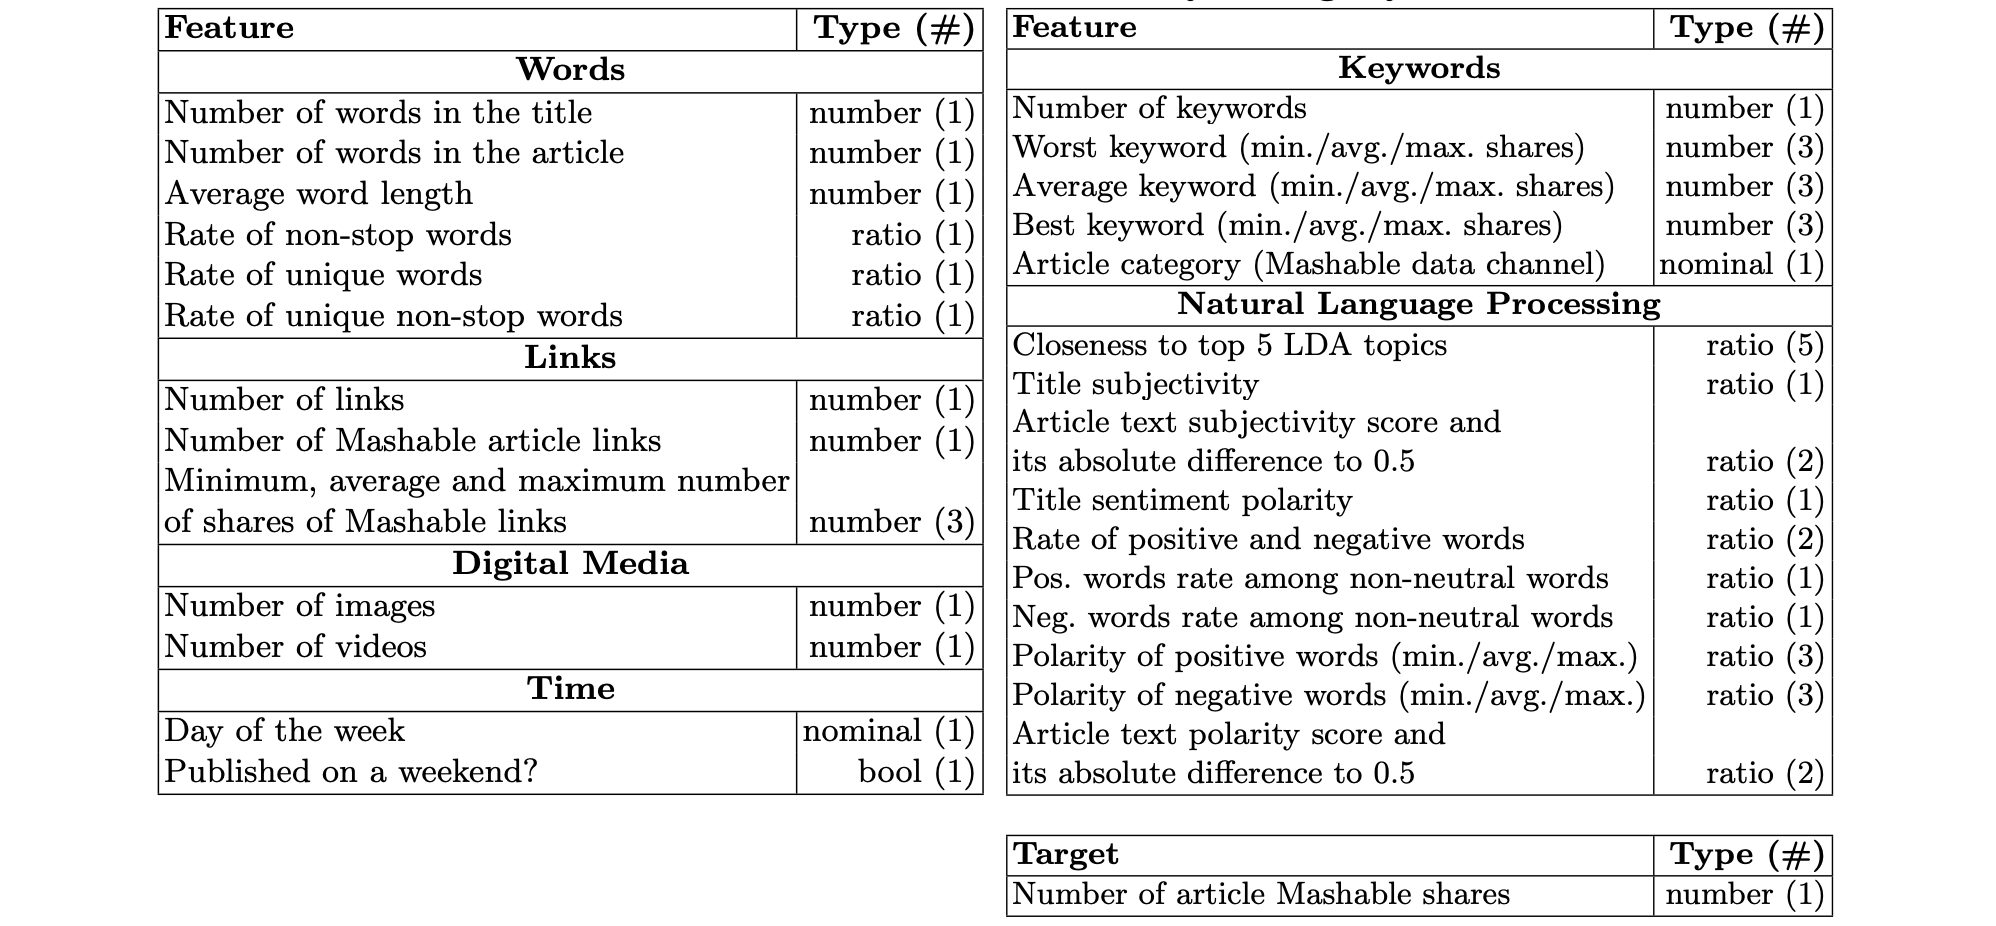

In [108]:
Image(filename="features.png")

In [109]:
word_features = ['n_tokens_title', 
                 'n_tokens_content', 
                 'n_unique_tokens', 
                 'n_non_stop_words', 
                 'n_non_stop_unique_tokens', 
                 'average_token_length']

media_features = ['num_imgs', 'num_videos']

temporal_features = ['weekday_is_monday', 
                     'weekday_is_tuesday', 
                     'weekday_is_wednesday',
                     'weekday_is_thursday',
                     'weekday_is_friday',
                     'weekday_is_saturday',
                     'weekday_is_sunday',
                     'is_weekend']

channel_features = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 
                    'data_channel_is_bus', 'data_channel_is_socmed', 
                    'data_channel_is_tech', 'data_channel_is_world']

keyword_features = ['kw_min_min', 'kw_max_min', 'kw_avg_min',
                    'kw_min_max', 'kw_max_max', 'kw_avg_max', 
                    'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
                    'num_keywords']


reference_features = ['num_hrefs',
                      'num_self_hrefs',
                      'self_reference_min_shares',
                      'self_reference_max_shares',
                      'self_reference_avg_sharess']

topic_features = ['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']

subjectivity_features = ['global_subjectivity', 'title_subjectivity', 'abs_title_subjectivity']

sentiment_features = ['global_sentiment_polarity', 'global_rate_positive_words',
                      'global_rate_negative_words', 'rate_positive_words',
                      'rate_negative_words', 'avg_positive_polarity',
                      'min_positive_polarity', 'max_positive_polarity',
                      'avg_negative_polarity', 'min_negative_polarity',
                      'max_negative_polarity', 'title_sentiment_polarity',
                      'abs_title_sentiment_polarity']

ids = ['id']

others = ['url']

target = ['shares']

## Cleaning Data: Handling of Missing Values and Outliers

### 1. word_features

In [110]:
# word_feature
100*data[word_features].isnull().sum()/len(data)

n_tokens_title              0.0
n_tokens_content            0.0
n_unique_tokens             0.0
n_non_stop_words            0.0
n_non_stop_unique_tokens    0.0
average_token_length        0.0
dtype: float64

No missing values in these features

In [111]:
# Lets check the describe and look for any outliers
data[word_features].describe(percentiles=[.25, .5, .75, .95, .99])

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,average_token_length
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,10.403861,545.376652,0.554071,1.004238,0.694586,4.542961
std,2.122101,471.476136,4.064623,6.039790,3.768884,0.855936
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,245.000000,0.471376,1.000000,0.626598,4.477124
50%,10.000000,407.000000,0.540000,1.000000,0.691275,4.663717
75%,12.000000,714.000000,0.609053,1.000000,0.754545,4.854545
95%,14.000000,1400.400000,0.721539,1.000000,0.857143,5.149363
99%,15.000000,2298.360000,0.803478,1.000000,0.921053,5.436190
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,8.041534


> We can clearly se that few features are having outliers, lets cap them with 1 lesser value

In [112]:
# Treating Outlier

for col in data[word_features]:
    percentiles = data[col].quantile([0.01, 0.96]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

<AxesSubplot:>

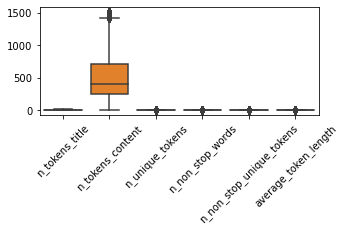

In [113]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(5,2))
plt.xticks(rotation=45)
sns.boxplot(data = data[word_features])

> word_feature are not having missing values but had outliers which has been cleaned.

Now lets see another feature: Media

### 2. media_features

In [114]:
# media_features missing values
100*data[media_features].isnull().sum()/len(data)

num_imgs      18.185181
num_videos     1.974237
dtype: float64

In [115]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
data[media_features] = imp.fit_transform(data[media_features])

In [116]:
# recheck media_features
100*data[media_features].isnull().sum()/len(data)

num_imgs      0.0
num_videos    0.0
dtype: float64

Missing values handled correctly

In [117]:
# Lets check the describe and look for any outliers
data[media_features].describe(percentiles=[.25, .5, .75, .95, .99])

,num_imgs,num_videos
count,29733.000000,29733.000000
mean,3.692127,1.238422
std,7.737912,4.120963
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,1.000000
95%,18.000000,6.000000
99%,35.000000,21.000000
max,128.000000,91.000000


We need to cap some outliers

In [118]:
# Treating Outlier

for col in data[media_features]:
    percentiles = data[col].quantile([0.01, 0.98]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

<AxesSubplot:>

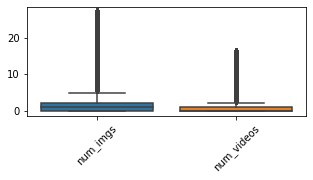

In [119]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(5,2))
plt.xticks(rotation=45)
sns.boxplot(data = data[media_features])

- We cannot cap completely the outliers as there may be loss of data, these outliers may occur due to huge gap between 0 & 1

> media_feature are having missing values and outliers which has been treated.

Now lets see another feature: temporal features

### 3. temporal_features

In [120]:
# temporal_features missing values
100*data[temporal_features].isnull().sum()/len(data)

weekday_is_monday       3.299364
weekday_is_tuesday      2.532540
weekday_is_wednesday    5.226516
weekday_is_thursday     1.005617
weekday_is_friday       2.912589
weekday_is_saturday     0.306057
weekday_is_sunday       5.031447
is_weekend              7.291562
dtype: float64

In [121]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
data[temporal_features] = imp.fit_transform(data[temporal_features])

In [122]:
# recheck temporal_features
100*data[temporal_features].isnull().sum()/len(data)

weekday_is_monday       0.0
weekday_is_tuesday      0.0
weekday_is_wednesday    0.0
weekday_is_thursday     0.0
weekday_is_friday       0.0
weekday_is_saturday     0.0
weekday_is_sunday       0.0
is_weekend              0.0
dtype: float64

Missing values handled correctly

As these are dummy variables there is no need to handle outliers as there are no outliers

### 4. channel_features

In [123]:
# channel_features missing values
100*data[channel_features].isnull().sum()/len(data)

data_channel_is_lifestyle        0.0
data_channel_is_entertainment    0.0
data_channel_is_bus              0.0
data_channel_is_socmed           0.0
data_channel_is_tech             0.0
data_channel_is_world            0.0
dtype: float64

> No missing values in this set of features

In [124]:
# Lets check the describe and look for any outliers
data[channel_features].describe(percentiles=[.25, .5, .75, .95, .99])

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,0.052669,0.175327,0.158275,0.058386,0.185047,0.213870
std,0.223375,0.380253,0.365005,0.234476,0.388342,0.410043
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We don't need to cap outliers, as these are dummies

> channel_feature are already clean.

Now lets see another feature: keyword features

### 5. keyword_features

In [125]:
# keyword_features missing values
100*data[keyword_features].isnull().sum()/len(data)

kw_min_min      3.645781
kw_max_min      1.533649
kw_avg_min      0.282514
kw_min_max      0.460767
kw_max_max      5.095349
kw_avg_max      0.393502
kw_min_avg      1.025796
kw_max_avg      2.290384
kw_avg_avg      3.272458
num_keywords    1.560556
dtype: float64

In [126]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
data[keyword_features] = imp.fit_transform(data[keyword_features])

In [127]:
# recheck media_features
100*data[keyword_features].isnull().sum()/len(data)

kw_min_min      0.0
kw_max_min      0.0
kw_avg_min      0.0
kw_min_max      0.0
kw_max_max      0.0
kw_avg_max      0.0
kw_min_avg      0.0
kw_max_avg      0.0
kw_avg_avg      0.0
num_keywords    0.0
dtype: float64

In [128]:
# Lets check the describe and look for any outliers
data[keyword_features].describe(percentiles=[.25, .5, .75, .95, .99])

,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,num_keywords
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,24.894023,1137.059125,310.249492,13590.766858,715069.047859,258882.171943,1110.020784,5529.192772,3038.298799,7.105338
std,68.213454,3980.267800,623.280348,57738.468137,265664.417136,135926.571472,1136.449313,6083.271032,1416.773534,2.097628
min,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,-1.000000,440.000000,140.250000,0.000000,690400.000000,172462.500000,0.000000,3528.983948,2332.670966,6.000000
50%,-1.000000,653.000000,233.375000,1400.000000,843300.000000,244440.000000,1010.666667,4306.940299,2839.076018,7.000000
75%,4.000000,1000.000000,354.600000,7900.000000,843300.000000,331760.000000,2048.888889,5990.275980,3570.338148,9.000000
95%,217.000000,2800.000000,688.480000,50700.000000,843300.000000,511233.333333,3190.596977,10364.512500,5199.369913,10.000000
99%,217.000000,10100.000000,1689.129524,208300.000000,843300.000000,635472.000000,3514.370789,23379.333333,6922.597750,10.000000
max,377.000000,298400.000000,42827.857143,843300.000000,843300.000000,843300.000000,3613.039819,298400.000000,43567.659946,10.000000


We need to cap some outliers as well as convert -1 to 0

In [129]:
# Treating Outlier

for col in data[keyword_features]:
    percentiles = data[col].quantile([0.01, 0.96]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

In [130]:
data[keyword_features].describe(percentiles=[.25, .5, .75, .95, .99])

,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,num_keywords
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,24.883463,857.847475,268.594826,8010.660579,715069.047859,255881.766814,1103.169488,5051.905082,2975.384894,7.105338
std,68.174465,732.121077,180.037512,14704.483315,265664.417136,127683.351308,1122.685494,2305.207748,1108.098571,2.097628
min,-1.000000,0.000000,-1.000000,0.000000,0.000000,9957.500000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,440.000000,140.250000,0.000000,690400.000000,172462.500000,0.000000,3528.983948,2332.670966,6.000000
50%,-1.000000,653.000000,233.375000,1400.000000,843300.000000,244440.000000,1010.666667,4306.940299,2839.076018,7.000000
75%,4.000000,1000.000000,354.600000,7900.000000,843300.000000,331760.000000,2048.888889,5990.275980,3570.338148,9.000000
95%,217.000000,2800.000000,688.480000,50700.000000,843300.000000,511233.333333,3190.596977,10364.512500,5199.369913,10.000000
99%,217.000000,3300.000000,765.006000,59000.000000,843300.000000,529424.071429,3257.913675,11445.105263,5386.342717,10.000000
max,217.000000,3300.000000,765.006000,59000.000000,843300.000000,529424.071429,3257.913675,11445.105263,5386.342717,10.000000


<AxesSubplot:>

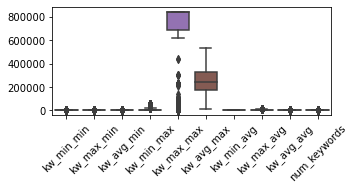

In [131]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(5,2))
plt.xticks(rotation=45)
sns.boxplot(data = data[keyword_features])

> Now lets move to another feature: reference features

### 6. reference_features

In [132]:
# rerference_features missing values
100*data[reference_features].isnull().sum()/len(data)

num_hrefs                      2.730972
num_self_hrefs                15.245687
self_reference_min_shares      0.955168
self_reference_max_shares      5.926075
self_reference_avg_sharess     1.089698
dtype: float64

In [133]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
data[reference_features] = imp.fit_transform(data[reference_features])

In [134]:
# recheck media_features
100*data[reference_features].isnull().sum()/len(data)

num_hrefs                     0.0
num_self_hrefs                0.0
self_reference_min_shares     0.0
self_reference_max_shares     0.0
self_reference_avg_sharess    0.0
dtype: float64

Missing values has been imputed 0, as it is relatable to nil share or links

In [135]:
# Lets check the describe and look for any outliers
data[reference_features].describe(percentiles=[.25, .5, .75, .95, .99])

,num_hrefs,num_self_hrefs,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,10.569939,2.784516,3911.480702,9841.393326,6356.054401
std,11.367170,3.737378,18685.461043,40373.818455,23584.977681
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,612.000000,753.000000,943.000000
50%,7.000000,2.000000,1200.000000,2500.000000,2200.000000
75%,13.000000,4.000000,2600.000000,7500.000000,5100.000000
95%,30.000000,8.000000,13340.000000,35400.000000,21474.285714
99%,55.000000,19.000000,52900.000000,96900.000000,69436.000000
max,304.000000,116.000000,843300.000000,843300.000000,843300.000000


In [136]:
# Treating Outlier

for col in data[reference_features]:
    percentiles = data[col].quantile([0.01, 0.98]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

<AxesSubplot:>

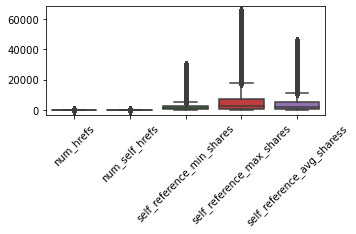

In [137]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(5,2))
plt.xticks(rotation=45)
sns.boxplot(data = data[reference_features])

Here also we are leaving outliers as it is, as we may loose some valuable data if we cap or change. This problem can be overcome when we use standardisation

> Now lets move to another feature: topic features

### 7. topic_features

In [138]:
# topic_features missing values
100*data[topic_features].isnull().sum()/len(data)

LDA_00    0.0
LDA_01    0.0
LDA_02    0.0
LDA_03    0.0
LDA_04    0.0
dtype: float64

No Missing values found

In [139]:
# Lets check the describe and look for any outliers
data[topic_features].describe(percentiles=[.25, .5, .75, .95, .99])

,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,0.185391,0.140411,0.217210,0.223688,0.233266
std,0.264106,0.218503,0.283237,0.295239,0.288963
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025060,0.025013,0.028571,0.028571,0.028574
50%,0.033389,0.033346,0.040005,0.040001,0.040771
75%,0.242018,0.150309,0.334032,0.376661,0.397958
95%,0.839716,0.708391,0.866582,0.866631,0.883395
99%,0.899957,0.885574,0.911058,0.910771,0.919499
max,0.926994,0.925947,0.919999,0.926534,0.927191


No Change needed

> Now lets see another feature: subjective features

### 8. subjectivity_features

In [140]:
# subjectivity_features missing values
100*data[subjectivity_features].isnull().sum()/len(data)

global_subjectivity       7.553896
title_subjectivity        0.430498
abs_title_subjectivity    2.687250
dtype: float64

In [141]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
data[subjectivity_features] = imp.fit_transform(data[subjectivity_features])

In [142]:
# recheck media_features
100*data[subjectivity_features].isnull().sum()/len(data)

global_subjectivity       0.0
title_subjectivity        0.0
abs_title_subjectivity    0.0
dtype: float64

Missing values handled correctly

In [143]:
# Lets check the describe and look for any outliers
data[subjectivity_features].describe(percentiles=[.25, .5, .75, .95, .99])

,global_subjectivity,title_subjectivity,abs_title_subjectivity
count,29733.000000,29733.000000,29733.000000
mean,0.409656,0.280857,0.333216
std,0.162660,0.324091,0.194064
min,0.000000,0.000000,0.000000
25%,0.376014,0.000000,0.142857
50%,0.444974,0.125000,0.500000
75%,0.502962,0.500000,0.500000
95%,0.595615,1.000000,0.500000
99%,0.682560,1.000000,0.500000
max,1.000000,1.000000,0.500000


<AxesSubplot:>

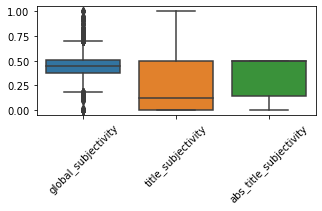

In [144]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(5,2))
plt.xticks(rotation=45)
sns.boxplot(data = data[subjectivity_features])

In [145]:
# Treating Outlier, only global_subjectivity needed to cap

percentiles = data['global_subjectivity'].quantile([0.01, 0.99]).values
data['global_subjectivity'][data['global_subjectivity'] <= percentiles[0]] = percentiles[0]
data['global_subjectivity'][data['global_subjectivity'] >= percentiles[1]] = percentiles[1]

> Now lets see another feature: sentiment features

### 9. sentiment_features

In [146]:
# sentiment_features missing values
100*data[sentiment_features].isnull().sum()/len(data)

global_sentiment_polarity       1.180507
global_rate_positive_words      2.808327
global_rate_negative_words      2.986581
rate_positive_words             1.974237
rate_negative_words             1.994417
avg_positive_polarity           4.163724
min_positive_polarity           1.496654
max_positive_polarity           0.501127
avg_negative_polarity           0.628931
min_negative_polarity           2.630074
max_negative_polarity           2.394646
title_sentiment_polarity        0.897992
abs_title_sentiment_polarity    4.900279
dtype: float64

In [147]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
data[sentiment_features] = imp.fit_transform(data[sentiment_features])

In [148]:
# recheck media_features
100*data[sentiment_features].isnull().sum()/len(data)

global_sentiment_polarity       0.0
global_rate_positive_words      0.0
global_rate_negative_words      0.0
rate_positive_words             0.0
rate_negative_words             0.0
avg_positive_polarity           0.0
min_positive_polarity           0.0
max_positive_polarity           0.0
avg_negative_polarity           0.0
min_negative_polarity           0.0
max_negative_polarity           0.0
title_sentiment_polarity        0.0
abs_title_sentiment_polarity    0.0
dtype: float64

Missing values imputed with zeros

In [149]:
# Lets check the describe and look for any outliers
data[sentiment_features].describe(percentiles=[.25, .5, .75, .95, .99])

,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_sentiment_polarity,abs_title_sentiment_polarity
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,0.117546,0.038443,0.016095,0.667924,0.282184,0.338465,0.094204,0.751322,-0.257428,-0.507499,-0.104434,0.070498,0.148002
std,0.097235,0.018406,0.010990,0.211751,0.159746,0.124853,0.072102,0.253540,0.129313,0.299198,0.095502,0.263945,0.223024
min,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.054932,0.027190,0.008982,0.590909,0.179487,0.296591,0.050000,0.600000,-0.327564,-0.700000,-0.125000,0.000000,0.000000
50%,0.117544,0.038348,0.015027,0.705882,0.275862,0.354545,0.100000,0.800000,-0.252469,-0.500000,-0.100000,0.000000,0.000000
75%,0.176650,0.049822,0.021515,0.800000,0.380952,0.408415,0.100000,1.000000,-0.184444,-0.300000,-0.050000,0.136364,0.250000
95%,0.276306,0.068129,0.035663,0.926829,0.555556,0.500000,0.200000,1.000000,0.000000,0.000000,0.000000,0.500000,0.600000
99%,0.372937,0.085315,0.051434,1.000000,0.701193,0.600000,0.400000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,0.655000,0.155488,0.184932,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000


<AxesSubplot:>

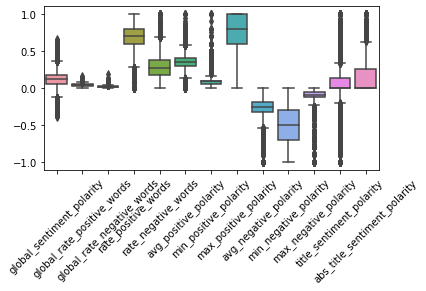

In [150]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(6,3))
plt.xticks(rotation=45)
sns.boxplot(data = data[sentiment_features])

In [151]:
# Treating Outlier, as we need to reduce outliers slightly else it may impact during standardisation due to low value

for col in data[sentiment_features]:
    percentiles = data[col].quantile([0.01, 0.99]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

<AxesSubplot:>

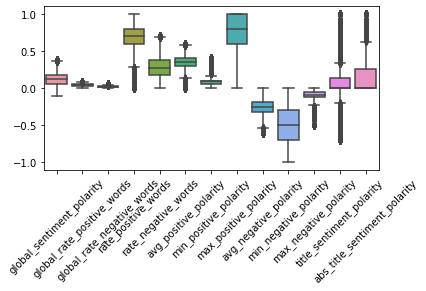

In [152]:
# Lets check the handled outliers using boxplot:

plt.figure(figsize=(6,3))
plt.xticks(rotation=45)
sns.boxplot(data = data[sentiment_features])

All missing values and outliers which were necessary are corrected.

> The feature cleaning is done, now lets combine the data and visualise further

## Data Visualisation:

In [153]:
# Combining all features to single variable

features = [*ids, *word_features, *media_features, 
            *temporal_features, *channel_features, 
            *keyword_features, *reference_features, 
            *topic_features, *subjectivity_features, 
            *sentiment_features, *others, *target]

len(features), len(data.columns)

(61, 61)

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             29733 non-null  int64  
 1   url                            29733 non-null  object 
 2   n_tokens_title                 29733 non-null  float64
 3   n_tokens_content               29733 non-null  float64
 4   n_unique_tokens                29733 non-null  float64
 5   n_non_stop_words               29733 non-null  float64
 6   n_non_stop_unique_tokens       29733 non-null  float64
 7   num_hrefs                      29733 non-null  float64
 8   num_self_hrefs                 29733 non-null  float64
 9   num_imgs                       29733 non-null  float64
 10  num_videos                     29733 non-null  float64
 11  average_token_length           29733 non-null  float64
 12  num_keywords                   29733 non-null 

In [155]:
data.describe()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,14866.000000,10.366562,521.729351,0.528549,0.969226,0.671295,10.179531,2.606195,3.401406,1.065954,4.535443,7.105338,0.052669,0.175327,0.158275,0.058386,0.185047,0.213870,24.883463,857.847475,268.594826,8010.660579,715069.047859,255881.766814,1103.169488,5051.905082,2975.384894,2944.790493,7277.590145,5017.761394,0.162345,0.182054,0.177715,0.182222,0.138802,0.061716,0.064676,0.120304,0.185391,0.140411,0.217210,0.223688,0.233266,0.409111,0.117637,0.038326,0.015995,0.667924,0.281318,0.337783,0.093167,0.751322,-0.256025,-0.507499,-0.102787,0.280857,0.072217,0.333216,0.148002,3439.840581
std,8583.322113,2.008423,377.052669,0.134391,0.172707,0.153066,9.206007,2.692189,6.084422,2.890169,0.848081,2.097628,0.223375,0.380253,0.365005,0.234476,0.388342,0.410043,68.174465,732.121077,180.037512,14704.483315,265664.417136,127683.351308,1122.685494,2305.207748,1108.098571,5393.475344,12805.245249,8430.596998,0.368773,0.385895,0.382279,0.386034,0.345746,0.240643,0.245957,0.325322,0.264106,0.218503,0.283237,0.295239,0.288963,0.161546,0.092852,0.018027,0.010526,0.211751,0.157025,0.122995,0.066018,0.253540,0.124108,0.299198,0.085190,0.324091,0.257995,0.194064,0.223024,12212.123341
min,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,9957.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.110161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.603014,-1.000000,-0.500000,0.000000,-0.700000,0.000000,0.000000,1.000000
25%,7433.000000,9.000000,245.000000,0.471376,1.000000,0.626598,4.000000,0.000000,0.000000,0.000000,4.477124,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,440.000000,140.250000,0.000000,690400.000000,172462.500000,0.000000,3528.983948,2332.670966,612.000000,753.000000,943.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025060,0.025013,0.028571,0.028571,0.028574,0.3

In [156]:
# Convert features to catagorical variables

data[temporal_features] = data[temporal_features].astype('category')
data[channel_features] = data[channel_features].astype('category')
data[topic_features] = data[topic_features].astype('category')
# Lets drop the non-essential featrues

data.drop(['is_weekend'], axis=1, inplace=True) # It is a repeatitive of weekdays included

In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   id                             29733 non-null  int64   
 1   url                            29733 non-null  object  
 2   n_tokens_title                 29733 non-null  float64 
 3   n_tokens_content               29733 non-null  float64 
 4   n_unique_tokens                29733 non-null  float64 
 5   n_non_stop_words               29733 non-null  float64 
 6   n_non_stop_unique_tokens       29733 non-null  float64 
 7   num_hrefs                      29733 non-null  float64 
 8   num_self_hrefs                 29733 non-null  float64 
 9   num_imgs                       29733 non-null  float64 
 10  num_videos                     29733 non-null  float64 
 11  average_token_length           29733 non-null  float64 
 12  num_keywords                   2

<AxesSubplot:>

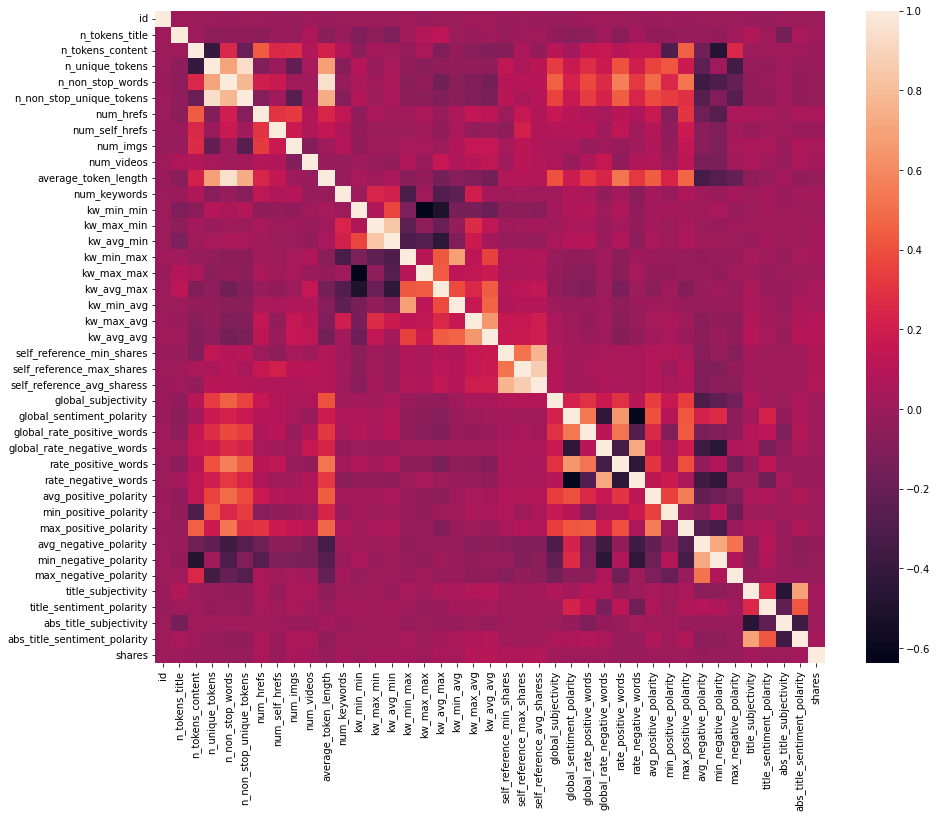

In [158]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr())

- Due to presence of large number of features we are unable to understand any visualisation technique right now but can interprete that there is no much correlation. So, lets move on to spliting the data

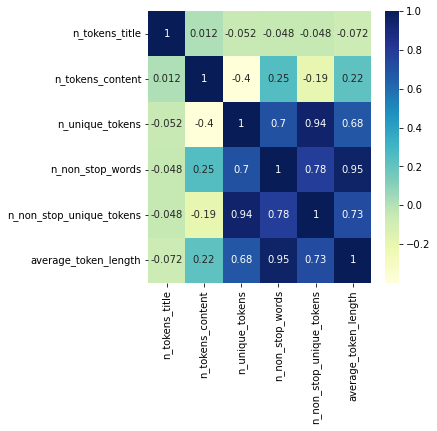

In [159]:
# heatmap for word_features
plt.figure(figsize=(5,5))
sns.heatmap(data[word_features].corr(),cmap="YlGnBu",annot=True) 
plt.show()

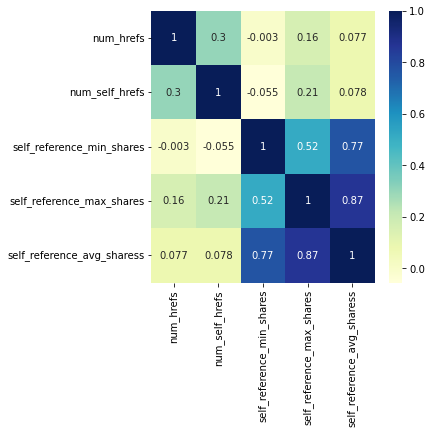

In [160]:
#  heatmap for reference_features
plt.figure(figsize=(5,5))
sns.heatmap(data[reference_features].corr(),cmap="YlGnBu",annot=True) 
plt.show()

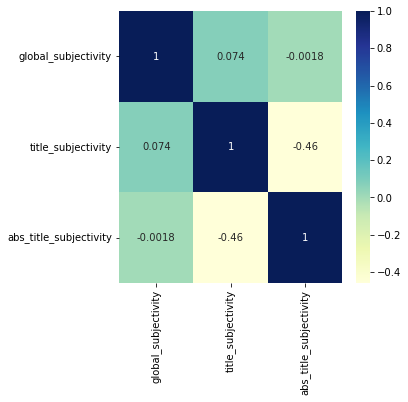

In [161]:
#  heatmap for subjectivity_features
plt.figure(figsize=(5,5))
sns.heatmap(data[subjectivity_features].corr(),cmap="YlGnBu",annot=True) 
plt.show()

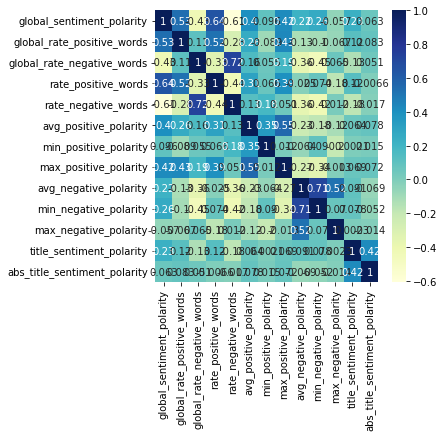

In [162]:
#  heatmap for sentiment_features
plt.figure(figsize=(5,5))
sns.heatmap(data[sentiment_features].corr(),cmap="YlGnBu",annot=True) 
plt.show()

## Defining target variable & features

In [163]:
# dividing data to train test:

X = data.drop(['id','url','shares'], axis=1) # select all columns except URL and TARGET
y = data["shares"]

In [164]:
print(X.shape,y.shape)

(29733, 57) (29733,)


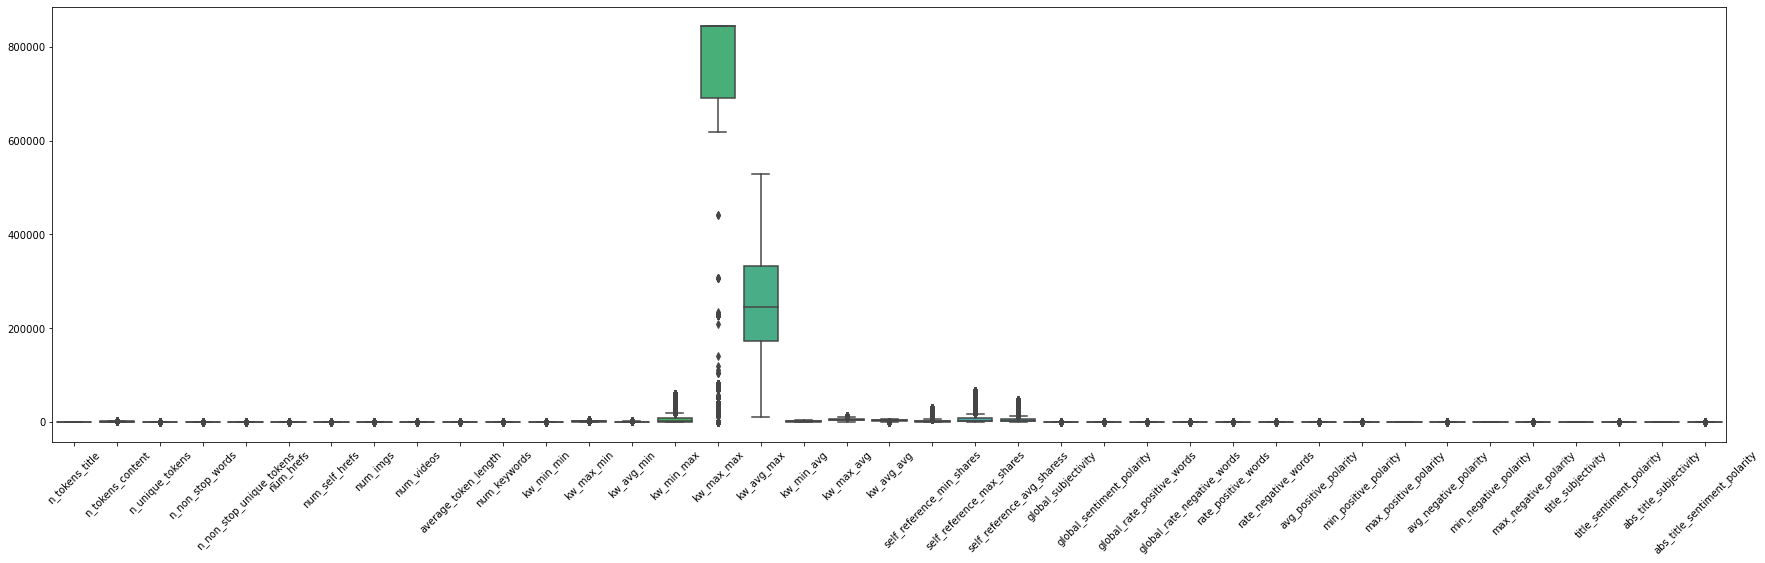

In [165]:
plt.figure(figsize=(30,8))
plt.xticks(rotation=45)
sns.boxplot(data = X)
plt.show()

## Standardising Data: Using StandardScaler

In [166]:
scaler = StandardScaler()

X[:] = scaler.fit_transform(X)

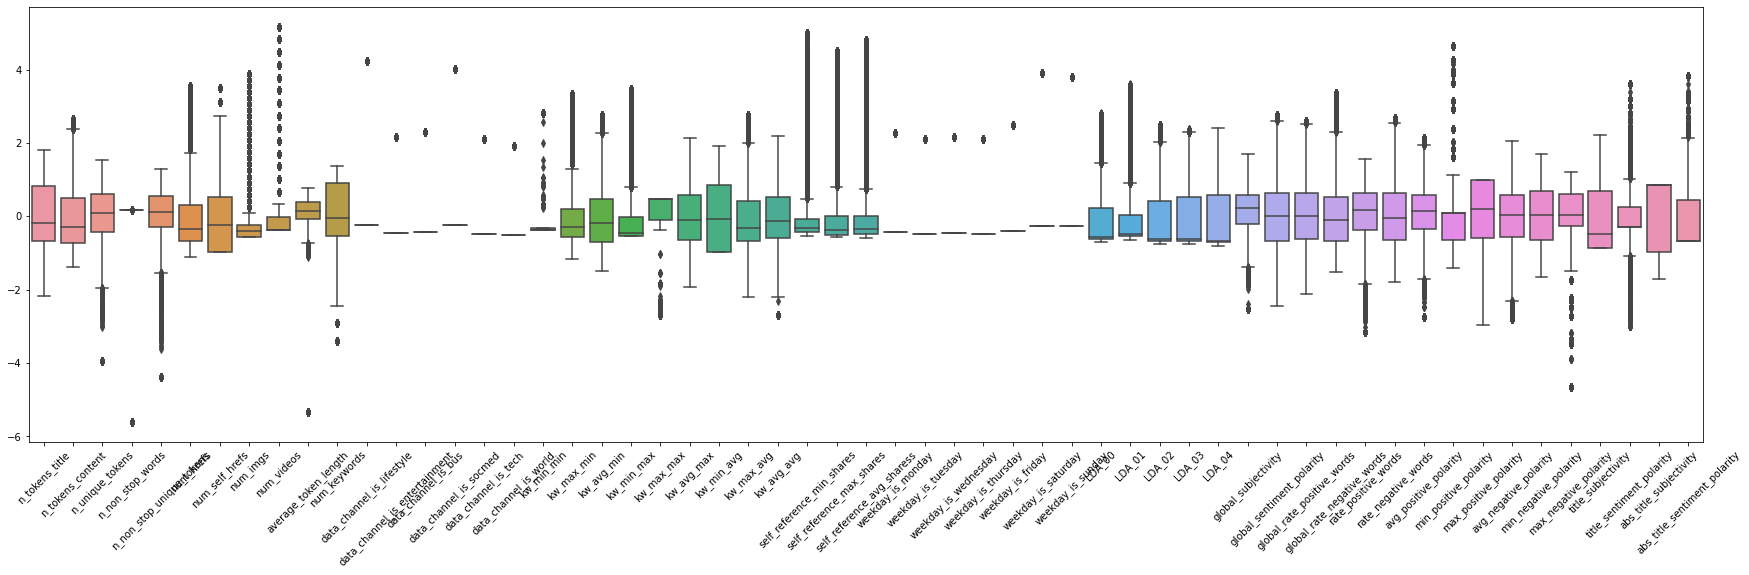

In [167]:
plt.figure(figsize=(30,8))
plt.xticks(rotation=45)
sns.boxplot(data = X)
plt.show()

In [168]:
X.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04,2.973300e+04
mean,1.207866e-16,7.673810e-17,1.427284e-16,1.469805e-16,4.966953e-16,9.233749e-17,-2.676691e-16,-2.393680e-15,5.042660e-16,9.407383e-16,-9.562339e-17,6.705604e-16,1.920757e-16,6.786930e-16,1.666233e-15,-3.182804e-16,1.948911e-16,5.391861e-18,5.996765e-17,-2.928296e-16,-6.163207e-17,6.367456e-16,-3.696935e-16,2.044053e-16,-2.198658e-16,2.839614e-16,1.546179e-16,1.111381e-16,-1.974825e-16,-3.486768e-16,-4.599922e-16,4.993035e-16,1.298871e-15,-1.659252e-15,1.552378e-15,-2.907169e-15,-7.475046e-17,1.780733e-17,5.918072e-17,4.921380e-18,4.980377e-17,-5.139743e-16,1.742647e-17,4.173689e-16,-2.885616e-17,-2.317343e-16,3.234669e-16,1.673941e-17,-1.676555e-16,1.018703e-16,1.232063e-16,-1.315405e-16,-2.437539e-17,9.166715e-16,-1.459533e-15,1.140655e-16,3.252965e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-2.174161e+00,-1.383727e+00,-3.933001e+00,-5.612048e+00,-4.385727e+00,-1.105767e+00,-9.680745e-01,-5.590446e-01,-3.688267e-01,-5.347980e+00,-3.387377e+00,-2.357901e-01,-4.610878e-01,-4.336322e-01,-2.490113e-01,-4.765129e-01,-5.215884e-01,-3.796715e-01,-1.171749e+00,-1.497462e+00,-5.447859e-01,-2.691670e+00,-1.926080e+00,-9.826332e-01,-2.191555e+00,-2.685172e+00,-5.460005e-01,-5.683384e-01,-5.951946e-01,-4.402371e-01,-4.717775e-01,-4.648907e-01,-4.720439e-01,-4.014638e-01,-2.564670e-01,-2.629597e-01,-7.019664e-01,-6.426168e-01,-7.668983e-01,-7.576651e-01,-8.072666e-01,-2.532519e+00,-2.453386e+00,-2.126026e+00,-1.519572e+00,-3.154337e+00,-1.791573e+00,-2.746352e+00,-1.411256e+00,-2.963372e+00,-2.795910e

## Model Building: Train Test Spliting

In [169]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y,train_size=0.7, test_size = 0.3, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(20813, 57) (20813,)
(8920, 57) (8920,)


## Feature Selection: RFE

In [170]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

rfe = RFE(lr, 15)             #selected top 15 features
rfe = rfe.fit(X_train, Y_train)

In [171]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('n_tokens_title', False, 4),
 ('n_tokens_content', False, 31),
 ('n_unique_tokens', False, 10),
 ('n_non_stop_words', False, 19),
 ('n_non_stop_unique_tokens', False, 14),
 ('num_hrefs', True, 1),
 ('num_self_hrefs', False, 2),
 ('num_imgs', False, 3),
 ('num_videos', False, 29),
 ('average_token_length', False, 6),
 ('num_keywords', False, 37),
 ('data_channel_is_lifestyle', True, 1),
 ('data_channel_is_entertainment', True, 1),
 ('data_channel_is_bus', True, 1),
 ('data_channel_is_socmed', True, 1),
 ('data_channel_is_tech', True, 1),
 ('data_channel_is_world', True, 1),
 ('kw_min_min', False, 23),
 ('kw_max_min', False, 24),
 ('kw_avg_min', False, 5),
 ('kw_min_max', False, 13),
 ('kw_max_max', False, 35),
 ('kw_avg_max', False, 38),
 ('kw_min_avg', False, 12),
 ('kw_max_avg', True, 1),
 ('kw_avg_avg', True, 1),
 ('self_reference_min_shares', False, 9),
 ('self_reference_max_shares', False, 8),
 ('self_reference_avg_sharess', True, 1),
 ('weekday_is_monday', False, 33),
 ('weekday

In [172]:
#The columns selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['num_hrefs', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'], dtype='object')

In [173]:
# will pass the above columns to X train and create a new df
X_train_rfe = X_train[col]
X_train_rfe.head()

,num_hrefs,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_max_avg,kw_avg_avg,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04
4585,-0.345382,-0.23579,-0.461088,2.306102,-0.249011,-0.476513,-0.521588,-0.343101,-0.339211,-0.209688,0.649239,1.043191,-0.649200,-0.644745,-0.087012
13413,-0.236755,-0.23579,-0.461088,2.306102,-0.249011,-0.476513,-0.521588,-0.697841,-0.962973,-0.507418,1.722221,0.454709,-0.625665,-0.622177,-0.668836
9073,-0.671261,-0.23579,2.168784,-0.433632,-0.249011,-0.476513,-0.521588,1.026153,1.327334,3.603867,-0.617823,0.348418,-0.688438,1.670214,-0.730362
28754,0.306378,-0.23579,2.168784,-0.433632,-0.249011,-0.476513,-0.521588,-0.537567,0.303687,-0.097001,1.180571,-0.482377,-0.648894,0.600638,-0.691796
21620,-0.562635,-0.23579,-0.461088,-0.433632,-0.249011,-0.476513,1.917221,-1.034755,-2.685172,-0.328305,-0.124646,-0.509583,0.509723,0.693017,-0.708324


In [174]:
# will pass the above columns to X test and create a new df
X_test_rfe = X_test[col]
X_test_rfe.head()

,num_hrefs,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_max_avg,kw_avg_avg,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04
17455,0.306378,-0.23579,-0.461088,-0.433632,4.015881,-0.476513,-0.521588,-2.191555,0.003574,0.341884,1.102832,-0.489871,0.727084,-0.644216,-0.691897
25193,-0.345382,-0.23579,-0.461088,-0.433632,-0.249011,-0.476513,1.917221,-0.637760,-0.788619,-0.298651,-0.550436,-0.459489,1.500687,-0.622155,0.015371
13154,-0.128128,-0.23579,-0.461088,-0.433632,-0.249011,-0.476513,1.917221,-0.641538,-0.605994,-0.479098,-0.575752,-0.490060,2.293011,-0.644760,-0.691901
6712,-0.671261,-0.23579,-0.461088,-0.433632,-0.249011,2.098579,-0.521588,-0.705985,-0.893749,-0.595195,0.386068,-0.528190,-0.678520,-0.672983,1.399330
29548,-0.236755,-0.23579,-0.461088,2.306102,-0.249011,-0.476513,-0.521588,2.773419,1.557361,0.375038,1.726284,0.448144,-0.625662,-0.621246,-0.668540


In [175]:
# Now applying PCA with the selected columns df
pca=PCA(random_state=42)
pca.fit(X_train_rfe)

PCA(random_state=42)

In [176]:
# let's see the two components of PCA
components = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'Feature':X_train_rfe.columns})
components

,PC1,PC2,Feature
0,0.110215,0.042026,num_hrefs
1,0.024304,-0.135090,data_channel_is_lifestyle
2,0.251644,0.210120,data_channel_is_entertainment
3,-0.013620,-0.309091,data_channel_is_bus
4,0.026781,-0.048822,data_channel_is_socmed
5,-0.189088,-0.359130,data_channel_is_tech
6,-0.349050,0.445495,data_channel_is_world
7,0.394068,0.055051,kw_max_avg
8,0.428702,-0.005507,kw_avg_avg
9,0.164582,-0.043053,self_reference_avg_sharess


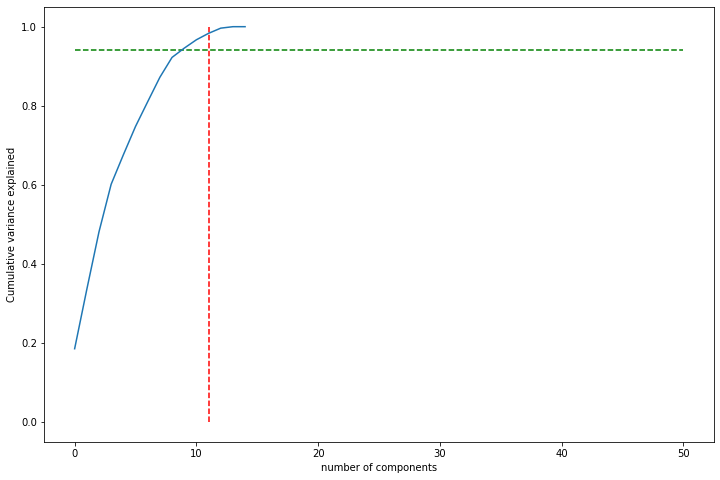

In [177]:
#Screeplot for the PCA components
fig = plt.figure(figsize=[12,8])
plt.vlines(x=11, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.94, xmax=50, xmin=0, colors="g", linestyles="--")
plt.plot( np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel("Cumulative variance explained")
plt.show()

In [178]:
#creating a dataframe for PCA on selected RFE columns (for trainset)
colnames = list(X_train_rfe.columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2],
                       'PC4':pca.components_[3],'PC5':pca.components_[4],
                       'PC6':pca.components_[5],'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],'PC11':pca.components_[10],'Feature':colnames})

In [179]:
#creating a dataframe for PCA on selected RFE columns  (for testset)
colnames = list(X_test_rfe.columns)
pca_df1 = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2],
                       'PC4':pca.components_[3],'PC5':pca.components_[4],
                       'PC6':pca.components_[5],'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],'PC11':pca.components_[10],
                       'PC12':pca.components_[11],'PC13':pca.components_[12],
                       'PC14':pca.components_[13],'PC15':pca.components_[14],'Feature':colnames})

In [180]:
#Creating a new df on 11 features for train data
X_train_pca = X_train_rfe[pca_df.Feature[:11]]
X_train_pca.head()

,num_hrefs,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_max_avg,kw_avg_avg,self_reference_avg_sharess,LDA_00
4585,-0.345382,-0.23579,-0.461088,2.306102,-0.249011,-0.476513,-0.521588,-0.343101,-0.339211,-0.209688,0.649239
13413,-0.236755,-0.23579,-0.461088,2.306102,-0.249011,-0.476513,-0.521588,-0.697841,-0.962973,-0.507418,1.722221
9073,-0.671261,-0.23579,2.168784,-0.433632,-0.249011,-0.476513,-0.521588,1.026153,1.327334,3.603867,-0.617823
28754,0.306378,-0.23579,2.168784,-0.433632,-0.249011,-0.476513,-0.521588,-0.537567,0.303687,-0.097001,1.180571
21620,-0.562635,-0.23579,-0.461088,-0.433632,-0.249011,-0.476513,1.917221,-1.034755,-2.685172,-0.328305,-0.124646


In [181]:
#Creating a new df on 11 features for test data
X_test_pca = X_test_rfe[pca_df1.Feature[:11]]
X_test_pca.head()

,num_hrefs,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_max_avg,kw_avg_avg,self_reference_avg_sharess,LDA_00
17455,0.306378,-0.23579,-0.461088,-0.433632,4.015881,-0.476513,-0.521588,-2.191555,0.003574,0.341884,1.102832
25193,-0.345382,-0.23579,-0.461088,-0.433632,-0.249011,-0.476513,1.917221,-0.637760,-0.788619,-0.298651,-0.550436
13154,-0.128128,-0.23579,-0.461088,-0.433632,-0.249011,-0.476513,1.917221,-0.641538,-0.605994,-0.479098,-0.575752
6712,-0.671261,-0.23579,-0.461088,-0.433632,-0.249011,2.098579,-0.521588,-0.705985,-0.893749,-0.595195,0.386068
29548,-0.236755,-0.23579,-0.461088,2.306102,-0.249011,-0.476513,-0.521588,2.773419,1.557361,0.375038,1.726284


In [182]:
# now doing final PCA with 9 components

pca_final = PCA(n_components=9)
df_train_pca = pca_final.fit_transform(X_train_pca)
df_train_pca.shape

(20813, 9)

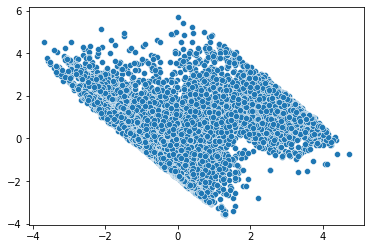

In [183]:
#Plotting first 2 PCA components
sns.scatterplot(x=df_train_pca[:,0], y=df_train_pca[:,1])
plt.show()

In [184]:
df_test_pca = pca_final.transform(X_test_pca)
df_test_pca.shape

(8920, 9)

## Base Models: As shown below

## 1. Linear Regression

In [185]:
# As we regularily require to check all errors, it is better to create a function
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [186]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(df_train_pca, Y_train)
# predict the testing pca data
train_predict = lm.predict(df_train_pca)
test_predict = lm.predict(df_test_pca)

print("Train metrics")
regression_results(Y_train.values.reshape(-1,),train_predict)

print()
print("Test metrics")
regression_results(Y_test.values.reshape(-1,),test_predict)

Train metrics
explained_variance:  0.0163
r2:  0.0163
MAE:  3177.0377
MSE:  157310283.0665
RMSE:  12542.3396

Test metrics
explained_variance:  0.0188
r2:  0.0187
MAE:  3100.5419
MSE:  121622527.254
RMSE:  11028.2604


## 2. Ridge Regression

In [187]:
# Lets select a range of the hyperparameters

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(df_train_pca, Y_train) 

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [188]:
# Find the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [189]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(df_train_pca, Y_train)
print(ridge.coef_)

[-540.29951107  886.55017475  188.47220277  324.86108448   54.34071467
 -328.5339232   399.9329225   207.47931708  -74.94529086]


In [190]:
# predict it now...
train_predict = ridge.predict(df_train_pca)
test_predict = ridge.predict(df_test_pca)

print("Train metrics")
regression_results(Y_train.values.reshape(-1,),train_predict)

print()
print("Test metrics")
regression_results(Y_test.values.reshape(-1,),test_predict)

Train metrics
explained_variance:  0.0163
r2:  0.0163
MAE:  3176.8477
MSE:  157310306.3265
RMSE:  12542.3405

Test metrics
explained_variance:  0.0188
r2:  0.0187
MAE:  3100.3091
MSE:  121621305.5134
RMSE:  11028.205


## 3. Lasso Regression

In [191]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(df_train_pca, Y_train) 

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [192]:
# Find the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 20}


In [193]:
#Fitting Lasso model for alpha = 10^-6 and printing coefficients which have been penalised

alpha =0.0001
lasso = Lasso(alpha=alpha)
        
lasso.fit(df_train_pca, Y_train) 

Lasso(alpha=0.0001)

In [194]:
lasso.coef_

array([-541.59057714,  888.73375304,  189.19519216,  326.16389962,
         54.57720264, -330.04486123,  401.99943   ,  208.60257512,
        -76.00188623])

In [195]:
# predict it now...
train_predict = lasso.predict(df_train_pca)
test_predict = lasso.predict(df_test_pca)

print("Train metrics")
regression_results(Y_train.values.reshape(-1,),train_predict)

print()
print("Test metrics")
regression_results(Y_test.values.reshape(-1,),test_predict)

Train metrics
explained_variance:  0.0163
r2:  0.0163
MAE:  3177.0377
MSE:  157310283.0665
RMSE:  12542.3396

Test metrics
explained_variance:  0.0188
r2:  0.0187
MAE:  3100.5418
MSE:  121622527.2085
RMSE:  11028.2604


## 4. Creating Submission file

In [196]:
# checking the unknown data
unseen.head()

,id,url,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,29733,http://mashable.com/2014/12/05/2014-cant-unsee/,10.0,564.0,0.505618,1.0,0.637394,21.0,1.0,0.0,3.0,4.723404,5.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,442.0,128.000000,23700.0,843300.0,340780.000000,2154.061235,3702.951220,2994.958581,2300.0,2300.0,2300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.040069,0.839887,0.040038,0.040006,0.442277,0.053681,0.037234,0.019504,0.65625,0.343750,0.269218,0.062500,0.6,-0.263636,-0.700000,-0.10,1.0,0.0,0.5,0.0
1,29734,http://mashable.com/2014/01/02/twitter-new-yea...,12.0,1127.0,0.431298,1.0,0.621622,10.0,6.0,11.0,0.0,4.360248,8.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,733.0,254.875000,6300.0,843300.0,140325.000000,1671.078652,4040.166667,2704.175559,3500.0,6300.0,4900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.025053,0.025040,0.025003,0.025000,0.899904,0.425115,0.159958,0.042591,0.014197,0.75000,0.250000,0.420924,0.033333,1.0,-0.243341,-0.714286,NaN,0.0,0.0,0.5,0.0
2,29735,http://mashable.com/2014/06/11/gopro-value-3-b...,10.0,400.0,0.564232,1.0,0.698795,1.0,0.0,1.0,1.0,4.765000,7.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,784.0,283.285714,6800.0,843300.0,166071.428571,1828.500000,3575.518291,2645.535689,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.028572,0.885666,0.028572,0.028620,0.028572,0.548466,0.011693,0.047500,0.032500,0.59375,0.406250,0.312286,0.136364,0.5,-0.354808,-0.800000,-0.15,0.0,0.0,0.5,0.0
3,29736,http://mashable.com/2014/10/08/spanish-ebola-d...,12.0,798.0,0.435279,1.0,0.613054,2.0,2.0,3.0,1.0,3.984962,9.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,796.0,284.222222,1800.0,843300.0,325322.222222,1059.333333,7735.494465,3966.507513,6300.0,6300.0,6300.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.022223,0.495422,0.022223,0.437909,0.022223,0.537687,0.028463,0.047619,0.033835,NaN,0.415385,0.359650,0.136364,1.0,-0.362912,-1.000000,-0.05,0.0,0.0,0.5,0.0
4,29737,http://mashable.com/2014/02/09/jennifer-lawren...,11.0,1010.0,0.464503,1.0,0.611727,32.0,2.0,1.0,0.0,5.180198,8.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,269.0,91.714286,0.0,843300.0,214137.500000,0.000000,3583.632001,2030.692327,1500.0,NaN,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.025536,0.025047,0.899314,0.025101,0.025002,0.412513,0.104127,0.025743,0.013861,0.65000,0.350000,0.375991,0.100000,0.8,-0.264286,-0.500000,NaN,0.0,0.0,0.5,0.0


In [197]:
submission_data = unseen.set_index('id')[X_train_pca.columns]
submission_data.shape

(9911, 11)

In [198]:
submission_data.head()

,num_hrefs,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_max_avg,kw_avg_avg,self_reference_avg_sharess,LDA_00
id,,,,,,,,,,,
29733,21.0,0.0,0.0,0.0,0.0,0.0,1.0,3702.951220,2994.958581,2300.0,0.040000
29734,10.0,0.0,0.0,0.0,0.0,1.0,0.0,4040.166667,2704.175559,4900.0,0.025053
29735,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3575.518291,2645.535689,0.0,0.028572
29736,2.0,0.0,1.0,0.0,0.0,0.0,0.0,7735.494465,3966.507513,6300.0,0.022223
29737,32.0,0.0,0.0,0.0,0.0,0.0,1.0,3583.632001,2030.692327,1500.0,0.025536


In [199]:
# Missing data in unseen data
missing_data_percent1=round(100 *(submission_data.isnull().sum()/len(submission_data.index)),2)
missing_data_percent1

num_hrefs                        2.76
data_channel_is_lifestyle        0.00
data_channel_is_entertainment    0.00
data_channel_is_bus              0.00
data_channel_is_socmed           0.00
data_channel_is_tech             0.00
data_channel_is_world            0.00
kw_max_avg                       2.27
kw_avg_avg                       2.95
self_reference_avg_sharess       1.03
LDA_00                           0.00
dtype: float64

In [200]:
# Imputing using SimpleImputer, for handling missing values
imp= SimpleImputer(strategy='constant', fill_value=0)
submission_data[:] = imp.fit_transform(submission_data[:])

In [201]:
#Rechecking the Null values again 
round(100 *(submission_data.isnull().sum()/len(submission_data.index)),2)

num_hrefs                        0.0
data_channel_is_lifestyle        0.0
data_channel_is_entertainment    0.0
data_channel_is_bus              0.0
data_channel_is_socmed           0.0
data_channel_is_tech             0.0
data_channel_is_world            0.0
kw_max_avg                       0.0
kw_avg_avg                       0.0
self_reference_avg_sharess       0.0
LDA_00                           0.0
dtype: float64

In [202]:
submission_data = pca_final.transform(submission_data)
submission_data.shape

(9911, 9)

In [203]:
# Selecting the final model based on lowest RMSE
# As all model give same RMSE, we are selecting Ridge Reg model
unseen["Shares"] = ridge.predict(submission_data)
output = unseen[['id','Shares']]
output.head()

,id,Shares
0,29733,5.454540e+06
1,29734,7.328497e+06
2,29735,3.489610e+06
3,29736,1.102240e+07
4,29737,4.214360e+06


In [204]:
# Save the column to new file for submission

output.to_csv('submission_govindsoni_13jun2022.csv',index=False)